## Exercise 1 

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). 

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

# Saving X and y as csv files 
X.tofile('X.csv', sep = ',')
y.tofile('y.csv', sep = ',')

b) Plot the singular value plot for a single example of the 0 digit 

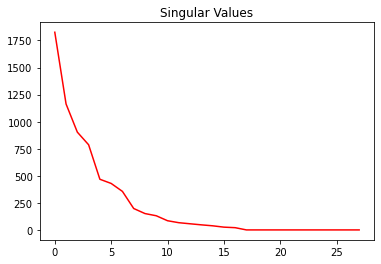

In [3]:
zero = X[1].reshape((28, 28)) # Single example of '0'
U, s, Vt = np.linalg.svd(zero)
plt.plot(s, color = 'red')
plt.title("Singular Values")
plt.show()

c) By setting some singular values to 0, plot the approximation of the 0 digit next to the original digit. 

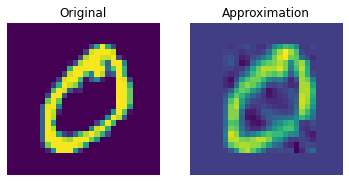

In [4]:
sCopy = s.copy()
sCopy[5:]=0 # Setting rank 5
zeroApprox = U.dot(np.diag(sCopy)).dot(Vt) # Computing the approximation
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(zero)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Approximation")
plt.imshow(zeroApprox)

d) Consider the entire dataset as a matrix. Perform SVD and store the dataset approximation in a new `.csv` file. Explain why / how you chose a particular rank.

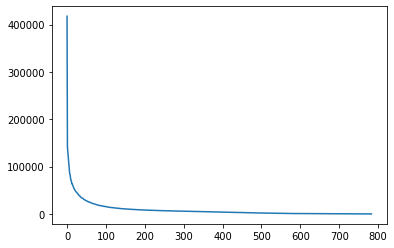

In [5]:
U, s, Vt = np.linalg.svd(X, full_matrices = False)
plt.plot(s)

In [6]:
sCopy = s.copy()
sCopy[10:] = 0 # Setting rank 10
dataApprox = U.dot(np.diag(sCopy)).dot(Vt) # Computing the approximation
dataApprox.tofile('dataApprox.csv', sep = ',')

From the singular values plot, it can be seen that the singular values diminish very quickly and becomes zero by the hundredth column. So, the number of most important features lie below that. Also, it is already known that the data is split into ten classes and so the rank is set to ten, capturing ten most important features in the approximation. 

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. 

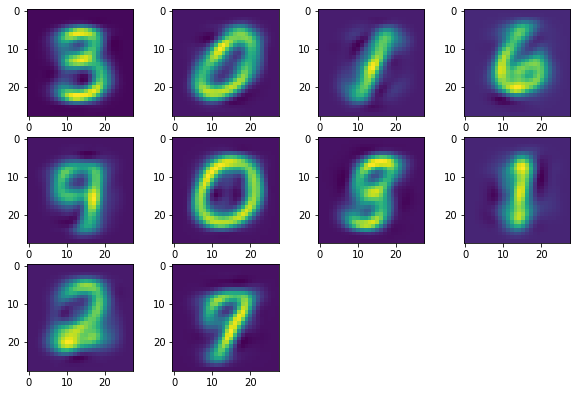

In [7]:
from sklearn.cluster import KMeans

approxClusters = KMeans(n_clusters = 10, random_state=0).fit(dataApprox)
approxCentroids = approxClusters.cluster_centers_.reshape(10, 28, 28)
plt.figure(figsize = (10, 9))
for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.imshow(approxCentroids[i])

f) Repeat e) on the original dataset. Comment on any differences (or lack thereof) you observe.

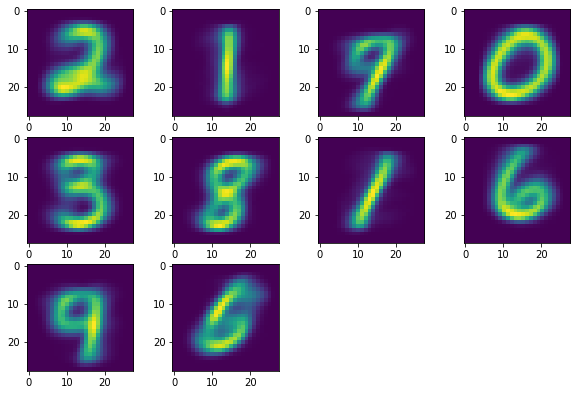

In [8]:
from sklearn.cluster import KMeans

dataClusters = KMeans(n_clusters = 10, random_state=0).fit(X)
dataCentroids = dataClusters.cluster_centers_.reshape(10, 28, 28)
plt.figure(figsize = (10, 9))
for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.imshow(dataCentroids[i])

It can be seen that the KMeans algorithm finds it more difficult to identify the clusters on the approximation. Two data points for 'zero' are computed as the centroids of two different clusters. The similar looking '3', '5', and '8' clusters are difficult to distinguish. On the original data, the centroids are all seen belonging to different classes.

g) Compare the disagreement distance of the clustering obtained in e) to the true labels, to the disagreement distance of the clustering obtained in f) to the true labels. Comment briefly. 

In [17]:
def optimizedDistance(clusters, labels):
    distance = 0
    total = 0

    labels_df = pd.DataFrame(labels, columns=['labels'])
    clusters_df = pd.DataFrame(clusters, columns=['clabels'])
    merged_df = pd.concat([labels_df, clusters_df], axis = 1)
    for label in merged_df['labels'].unique():
        filteredData = merged_df.loc[merged_df['labels'] == label]
        countData = filteredData['clabels'].value_counts().to_list()
        for i in range(len(countData)):
            distance = distance + (countData[i] * sum(countData[i:]))
    for label in merged_df['clabels'].unique():
        filteredData = merged_df.loc[merged_df['clabels'] == label]
        countData = filteredData['labels'].value_counts().to_list()
        for i in range(len(countData)):
            distance = distance + (countData[i] * sum(countData[i:]))

    return distance




def disagreement_dist(P_labels, C_labels):
    return optimizedDistance(P_labels, C_labels)

 

y = y.astype(np.int32)
print("Disagreement distance after clustering Original data = ",disagreement_dist(dataClusters.labels_, y))
print("Disagreement distance after clustering Approx data = ",disagreement_dist(approxClusters.labels_, y))

Disagreement distance after clustering Original data =  728276414
Disagreement distance after clustering Approx data =  721642191


It can be seen that the disagreement distances are almost similar. Seeing how nearly the same clustering result can be obtained with an approximation of the data where the number of features is greatly reduced, the approximate data can be chosen for all expensive computations and can be expected to give more or less the same result. 

h) Create a matrix that is the difference between the original dataset and the rank-10 approximation of the dataset.

In [8]:
difference = X - dataApprox
difference

array([[-2.62272593e-15, -6.43881257e-13, -1.15083476e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.46363890e-15, -6.12161381e-13, -2.00000557e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.88487181e-16, -1.81610447e-13,  1.55794181e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 6.60028706e-16, -4.54429482e-13,  4.10742751e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.59076933e-16, -4.80495423e-13, -3.85798607e-15, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02674393e-16, -8.33247635e-13,  4.03036718e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

i) The largest (using euclidean distance from the origin) rows of the matrix could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows. 

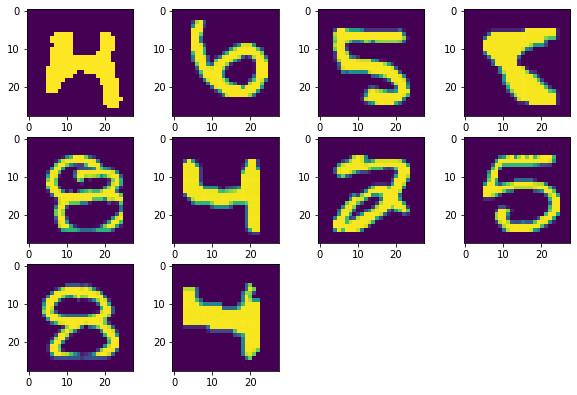

In [10]:
# Find the Euclidean distance between every data point and origin
sum = 0
list = []
for i in range(70000):
    for j in range(784):
        sum = sum + (difference[i][j] ** 2)
    value = sum ** (1/2)
    list.append(value)
    sum = 0

# Find the largest rows of the matrix
ind = []
for i in range(10):
    max_index = list.index(max(list))
    ind.append(max_index)
    list[max_index] = 0

# Plot the outliers
plt.figure(figsize = (10, 9))
for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[ind[i]].reshape((28, 28)))

These points can be considered as outliers because they vary the most from the original representation when the rank 10 approximation is computed, indicating that unlike other data points, the most important features (captured by the first ten sigma values) of these data points are actually not characteristic of the class they belong to. 

## Exercise 2 

a) Modify the code below to pick 4 categories of news articles that you think are minimally related (for example `sci.space` and `rec.sport.baseball`).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)

b) Using the `SnowballStemmer`, stem the words in every article 

In [23]:
from nltk.tokenize import word_tokenize
data = news_data['data']
stemmedData = []
snowball = SnowballStemmer("english")
for article in data:
    tokens = word_tokenize(article)
    stemmedData.append(' '.join([snowball.stem(word) for word in tokens]))

c) Use the `TfidfVectorizer` on the stemmed articles. Set `min_df` and `max_df` to reasonable numbers and briefly explain your reasoning. Store the resulting dataset into a `.csv` file. 

In [42]:
import pandas as pd
import scipy as sp
tfidf = TfidfVectorizer(min_df= 0.1, max_df=0.9)
tfs = tfidf.fit_transform(stemmedData)
tfsArray = tfs.toarray()
# Saving as csv file 
tfsArray.tofile('tfs.csv', sep = ',')

max_df has been set to 90% on the basis that any word that appears in 90% of the articles can potentially be a stop word and therefore need not be considered. min_df is set to 10% ignoring words which appear in less than 10% of the articles and are not potentially considered characterictic of any class.

d) For rank k ranging from 1 to 25:

1. Reduce the dimensionality of the tfidf vectorized data using a dimension reduction technique discussed in class.
2. Apply Kmeans on the reduced dataset to create 4 clusters
3. Record the disagreement distance between the clustering in 2 and the article category

Then plot the recorded disagreement distance per rank. Comment briefly.

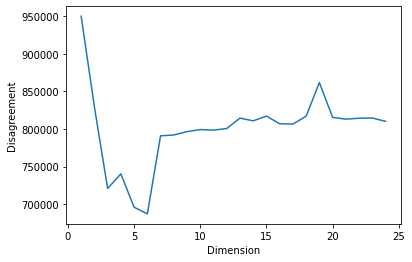

In [44]:
from sklearn.decomposition import PCA
disagreement_distance = []
for k in range(1,25):
    dim_reduced_dataset = PCA(n_components = k).fit_transform(tfsArray) # Using PCA for dimensionality 
    kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(dim_reduced_dataset)
    labelsk = kmeans.labels_
    disagreement_distance.append(disagreement_dist(labelsk, news_data.target))

plt.plot(range(1,25), disagreement_distance)
plt.ylabel('Disagreement')
plt.xlabel('Dimension')
plt.show()

As expected, the disagreement distance is very high when only one or two features are chosen. The best clustering results are obtained when 6 feactures are chosen from PCA for clustering. After that, a steady though higher disagreement distance can be observed.